# **Business Problem Statement**  

## **Enhancing Customer Support with an Intelligent Web-Connected Chatbot**  

In today's fast-paced digital world, businesses strive to provide seamless customer support that is **accurate, instant, and personalized**. Traditional support systems often struggle with **outdated knowledge bases, lack of real-time information, and fragmented user experiences across multiple sessions**.  

To address these challenges, we propose building an **AI-driven support chatbot** with the following capabilities:  

- **Web-Enabled Knowledge Retrieval** – Unlike static chatbots, our AI can **search the web in real-time** to provide the most up-to-date answers, ensuring customers receive **current and relevant** information.  
- **User-Level Memory Retention** – The chatbot maintains **context across user sessions**, allowing for more natural and personalized interactions instead of treating every conversation as a new one.  
- **Seamless Automation** – The AI reduces the burden on human support agents by **automating responses** to common queries, enhancing efficiency, and lowering operational costs.  

This project serves as a **blueprint** for businesses looking to enhance customer service through AI-powered chatbots, **improving user experience, reducing response times, and fostering customer loyalty**.  

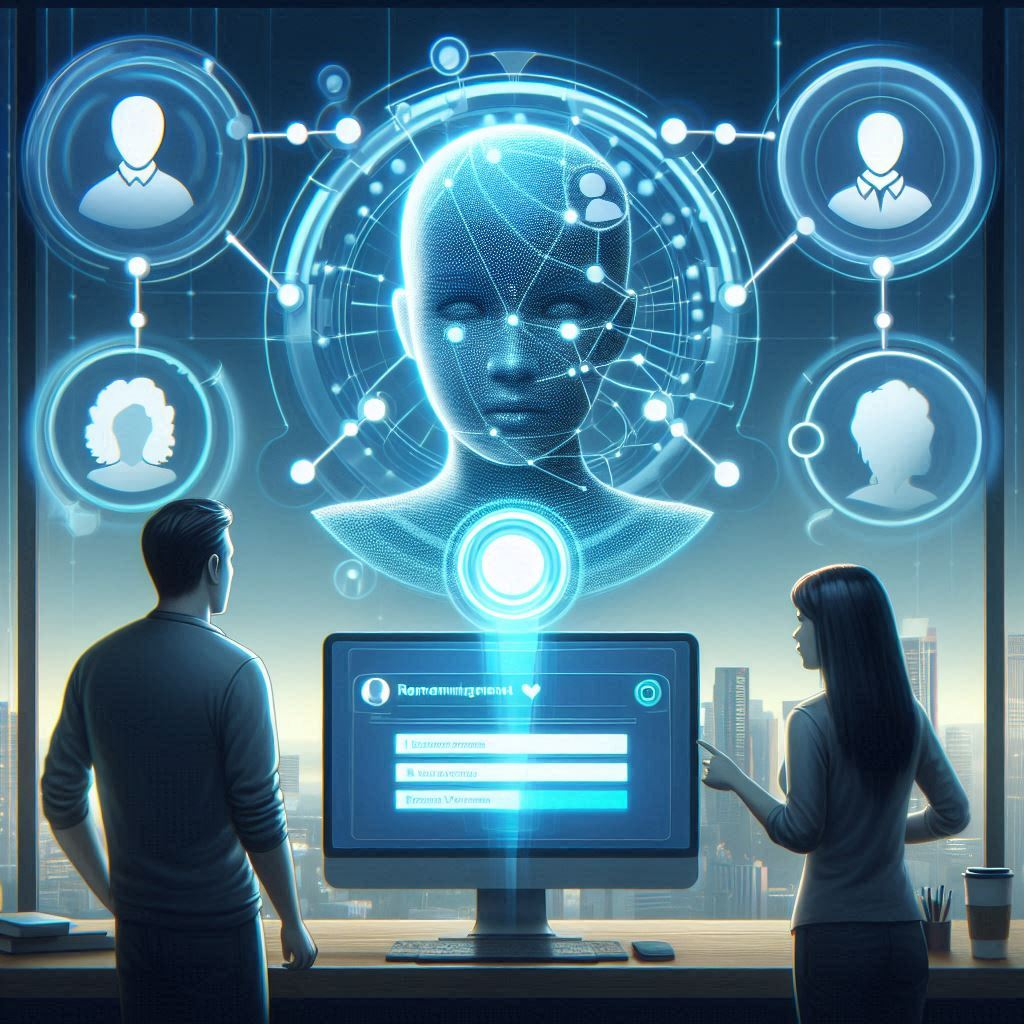

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/GL-GenAI/Week13-AdvancedGenAI')
os.listdir()

['self_reflection_demo_with_langgraph_executed.ipynb',
 '.env',
 'langgraphTutorials',
 'SM-self_reflection_demo_with_langgraph_executed.ipynb',
 'Travel_agent_with_reflection_and_Memory_executed+%281%29.ipynb',
 'SM-Travel_agent_with_reflection_and_Memory_executed+%281%29.ipynb']

In [44]:
#%%writefile .env
# OPENAI_API_KEY=""
#jina_api_key = ""
#mem0_api_key = ""

In [4]:
pip install -q python-dotenv

In [40]:
import openai
from dotenv import load_dotenv

In [41]:
# Set environment variable to avoid tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Force reload of environment variables
load_dotenv(override=True)

True

In [43]:
# Set the OpenAI API key from the environment variable
openai.api_key = os.getenv('OPENAI_API_KEY')
jina_api_key = os.getenv('jina_api_key')
mem0_api_key = os.getenv('mem0_api_key')
# print(openai.api_key)   # only for testing
# print(jina_api_key)
# print(mem0_api_key)

## Setup

**Mem0 (pronounced “mem-zero”**) is a Python library designed to enhance AI assistants and agents by providing an intelligent memory layer. This allows AI systems to remember user preferences, adapt to individual needs, and continuously improve over time, leading to more personalized interactions.  ￼

**Key Features:**

	•	Multi-Level Memory: Supports retention of user, session, and AI agent memories, enabling adaptive personalization. ￼
	•	Developer-Friendly: Offers a simple API for easy integration across various applications and platforms.
	•	Cross-Platform Consistency: Ensures uniform behavior across different devices. ￼
	•	Managed Service: Provides a hassle-free hosted solution for developers. ￼

**Use Cases:**

	•	AI Assistants: Facilitates seamless, context-aware conversations. ￼
	•	Learning & Support: Delivers tailored content recommendations and context-aware customer assistance. ￼
	•	Healthcare & Companions: Tracks patient history and fosters deeper relationships. ￼
	•	Productivity & Gaming: Streamlines workflows and adapts environments based on user behavior.

In [8]:
! pip install -q openai==1.55.3 \
                 mem0ai\
                 langchain \
                 langchain-openai \
                 langgraph \
                 chromadb \
                 langchain-chroma \
                 duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.0 MB/s eta 0

- **DDGS is a Python class** from the duckduckgo_search package that allows you to perform searches using DuckDuckGo programmatically.


In [10]:
import json

from langchain import hub

from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from langchain_openai import AzureChatOpenAI

from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from IPython.display import Image, display


from typing import List, Dict
import requests
import json
from duckduckgo_search import DDGS

Get Jina API key from [here](https://jina.ai/reader/)

Click on <> API button

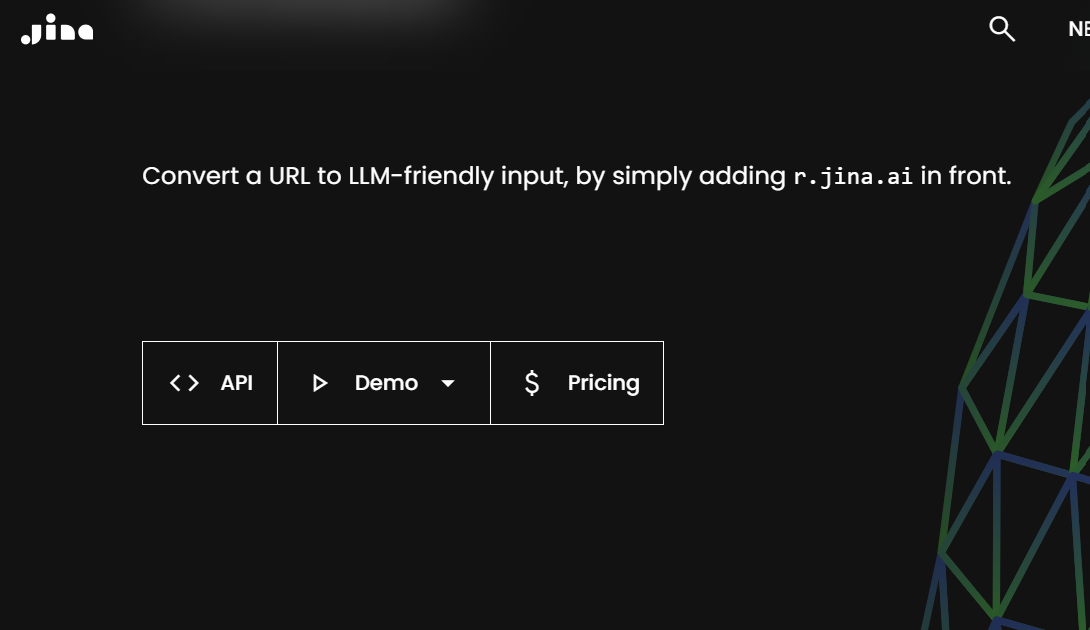

Scroll down to the bottom to find the api key

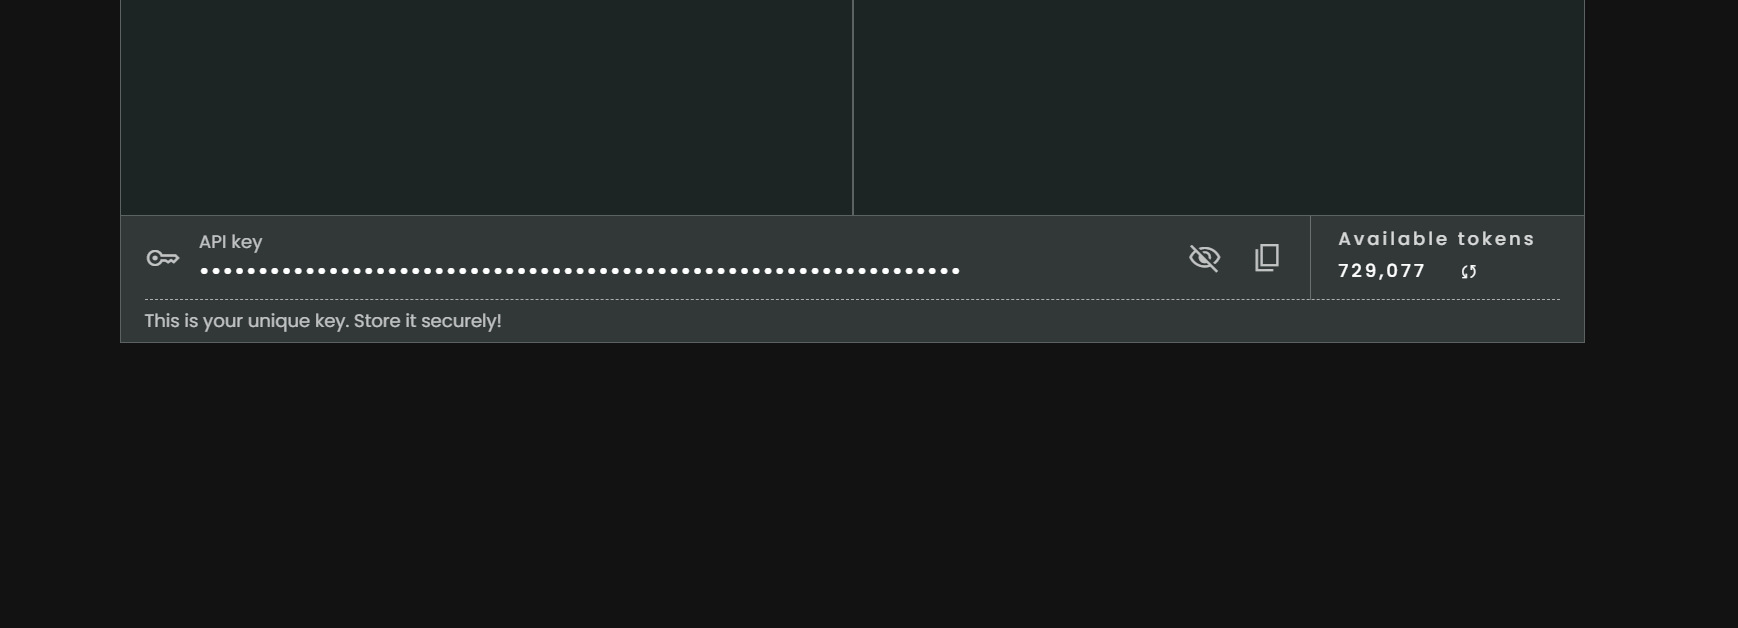

In [9]:
# with open ('config_4o.json') as f:

#     cred1 = json.load(f)

In [ ]:
# llm = AzureChatOpenAI(
#     api_key=cred1['AZURE_OPENAI_KEY'],
#     azure_endpoint=cred1['AZURE_OPENAI_ENDPOINT'],
#     api_version=cred1['AZURE_OPENAI_APIVERSION'],
#     model="gpt-4o",
#     temperature=0
# )
# jina_api_key = ""

# minillm = AzureChatOpenAI(api_key=cred1['AZURE_OPENAI_KEY'],
#     azure_endpoint=cred1['AZURE_OPENAI_ENDPOINT'],
#     api_version=cred1['AZURE_OPENAI_APIVERSION'],
#     model="gpt-4o",
#     temperature=0
# )

In [11]:
from langchain_openai import ChatOpenAI

In [12]:
llm = ChatOpenAI(model="gpt-4o",
                 api_key= openai.api_key,
                 temperature=0)

# Building a Web Search Agent with Expert led Reflection Using LangGraph

This web search agent operates as follows:

1. **Expand Search Queries**:  
   The agent takes the initial user input or query and expands it. This step ensures that the query covers a broader range of potential results by generating related or refined search terms.

2. **Get DuckDuckGo Results**:  
   Using the expanded search queries, the agent fetches relevant search results from DuckDuckGo. These results include URLs that potentially contain useful information.

3. **Filter URLs**:  
   The fetched URLs are then filtered based on predefined criteria, such as relevance, content type, or trustworthiness. This ensures that only high-quality links are considered for further processing.

4. **Fetch Site Content**:  
   The filtered URLs are accessed, and the content from the corresponding web pages is retrieved. This involves parsing the HTML or structured data from the sites.

5. **Rewrite**:  
   Optionally, the agent may rewrite or summarize the retrieved content for uniformity or enhanced readability.

6. **Final Output**:  
   After processing the content, the agent organizes the data into a structured format, ready to be presented to the user.

7. **Print Output**:  
   The final output is displayed or returned to the user. This step marks the completion of the search task.

   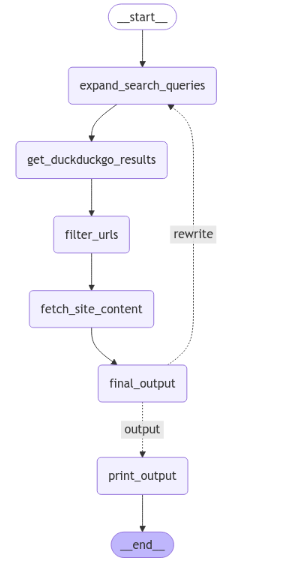


We shall build a customer support chatbot on top of this web search agent that can store user details using Mem0.

In [21]:
from typing import TypedDict, List, Dict, Sequence
from typing_extensions import Annotated

class State(TypedDict):
    """
    Represents the state of the chatbot at any given moment.
    This dictionary-like structure stores essential information
    required to maintain conversation context, handle web searches,
    filter results, and generate responses.
    """

    # Stores the chat history (list of messages exchanged in the conversation).
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # The latest query from the user that the chatbot is processing.
    query: str

    # A list of expanded search queries derived from the user’s original query.
    expanded_search: List[str]

    # A list of dictionaries containing search results retrieved from the web.
    # Each dictionary may have keys like 'title', 'url', and 'snippet'.

    # 1.	List[...] → This means search_results is a list.
    # 2.	Dict[str, str] → Each item in the list is a dictionary where:
    # •	The keys are str (strings) → e.g., "title", "url", "snippet".
    # •	The values are also str (strings) → e.g., the actual title, URL, and snippet of a search result.

    search_results: List[Dict[str, str]]

    # Maximum number of search results to be considered or processed.
    max_results: int

    # A list of URLs that have been filtered based on relevance or other criteria.
    filtered_urls: List[str]

    # Extracted useful information from search results (e.g., key facts, summaries).
    info: List[str]

    # User-provided feedback on the chatbot's response (useful for refining answers).
    feedback: str

    # The final generated response that will be sent back to the user.
    output: str


In [22]:
search_agent = StateGraph(State)

In [23]:
def expand_search_queries(state):
    """
    Use the core LLM to expand a natural language user request into multiple related search queries.
    """
    print("---EXPAND SEARCH QUERIES---")
    query  = state['query']

    system_prompt = """You are a helpful research assistant that is well versed with crafting searching queries \
            for google to get accurate and relevant results.
            Return 3 related search queries based on the user's request seperated by newline.
            Use the feeback if provided to craft the search query"""

    prompt = f"Expand the following request into a list of related search queries:\n\n'{query} \n feedback: {state['feedback']}'"

    response = llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )
    expanded_queries = response.content.strip().split('\n') # strip().split('\n') → Turns response.content into a list of lines.
    expanded_queries = [query.strip() for query in expanded_queries if query.strip()] # if query.strip() filters out empty strings, keeping only meaningful queries.

    print("expanded_search_queries: \n", expanded_queries)

    return {"expanded_search": expanded_queries}

In [24]:

def get_duckduckgo_results(state):
    """
    Use DuckDuckGo to search for a query and return a list of search results.
    """
    print("---GETTING DUCKDUCKGO RESULTS---")
    results = []
    for query in state['expanded_search']:
        with DDGS() as ddgs:
            results.extend(ddgs.text(query, max_results=state['max_results']))
    return {"search_results": results}

In [25]:


def filter_urls(state):
    """
    Use the core LLM to filter out irrelevant URLs based on the context of the user's request.
    """
    print("---FILTER URLS---")

    prompt = f"Filter out irrelevant URLs from the following list based on the context of the user's request:\
        request: {state['query']}\n\n responses {state['search_results']} \
        Respond back with a list of URls relevant to the query. Do not explain your answer. Return only the URLs."
    system_prompt = "You are a helpful assistant expert at filtering out irrelevant search results. \
                    Your task is to select only those URLs that are relevant to the user's request."
    response = llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )
    filtered_urls = response.content.strip().split('\n')
    filtered_urls = [url.strip() for url in filtered_urls if url.strip()]
    print("filtered_urls: \n", filtered_urls)
    # if len(filtered_urls) <= 2:
    #     return "FAIL"
    return {"filtered_urls": filtered_urls}

In [26]:
def fetch_site_content(state):
    """
    Fetch and return the content of the given URL using requests and BeautifulSoup.

    mentions BeautifulSoup, but the function itself does not actually use it.
    Instead, it is making an API request to https://r.jina.ai/ and using the response directly.
    """
    print("---FETCH SITE CONTENT---")

    info = []
    headers = {
        "Authorization": f"Bearer {os.getenv('jina_api_key')}",  # Fetch API key from environment
        "Content-Type": "application/json",
        "X-Timeout": "10",
        "X-Token-Budget": "20000"
    }
    for url in state['filtered_urls']:    # 	Prepares a JSON payload containing the URL.
        data = {
            "url": url
        }

        response = requests.post("https://r.jina.ai/", headers=headers, json=data)
        content = summarize_content(state['query'],response.text) + "\n\n URL: " + url
        info.append(content)
    return {"info": info}


In [27]:

def summarize_content(query: str, content: str):
    """
    Summarize the content using the core LLM.

    Args:
        query (str): The user's query
        content (str): The content to be summarized

    Returns:
        str: The summarized content
    """
    print("---SUMMARIZE CONTENT---")

    system_prompt = """you are an expert at condensing information. Your task is to extract relevant information for a given query"""
    prompt = f"Extract information from the following content only relevant to the following question: {query}\n\n{content}"

    response = llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ]
    )
    return response.content.strip()



In [28]:
def final_output(state):
    """
    Summarize the content using the core LLM.

    Args:
        state (messages): The current state

    Returns:
        str: The final output
    """

    print("---CRAFTING FINAL RESPONSE---")
    system_prompt = """You are a helpful research assistant that is well versed with crafting responses using the information \
        you have gathered from various sources. You have to summarize the information you have gathered and present it in a coherent manner.
        Add citations to the source using numbers in the response and end the response with the list of sources links used in the response."""

    prompt = f"Summarize the following information to answer the query provided: query {state['query']} \n\n  content {state['info']}"

    response = llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=prompt)
        ])
    return {"output": response.content.strip()}

In [29]:
def grade_output(state):
    """
    Determines whether the retrieved information is relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the answer is relevant or not
    """

    print("---GRADING ANSWERS---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")
        feedback: str = Field(description="Feedback on how to improve keywords or original query to fetch relevant search results")


    # LLM with tool and validation
    llm_with_SO = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved information to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the information is enough to answer the question, return yes  \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_SO

    scored_result = chain.invoke({"question": state['query'], "context": state['info']})

    score = scored_result.binary_score
    state['feedback'] = scored_result.feedback


    if score == "yes":
        print("---DECISION: INFO RELEVANT---")
        return "output"

    else:
        print("---DECISION: INFO NOT RELEVANT---")
        print(scored_result.feedback)
        return "rewrite"


def print_output(state):
  print("---FINAL OUTPUT---")
  print(state['output'])

Let's Initiate the Graph by adding Nodes

In [30]:
search_agent = StateGraph(State)
search_agent.add_node("expand_search_queries", expand_search_queries)
search_agent.add_node("get_duckduckgo_results", get_duckduckgo_results)
search_agent.add_node("filter_urls", filter_urls)
search_agent.add_node("fetch_site_content", fetch_site_content)
search_agent.add_node("final_output", final_output)
search_agent.add_node("print_output",print_output)

Let's connect these nodes using edges to make a graph

In [31]:

search_agent.add_edge(START, "expand_search_queries")
search_agent.add_edge("expand_search_queries", "get_duckduckgo_results")
search_agent.add_edge("get_duckduckgo_results", "filter_urls")
search_agent.add_edge("filter_urls", "fetch_site_content")
search_agent.add_edge("fetch_site_content", "final_output")
search_agent.add_conditional_edges("final_output", grade_output,
                                   {
                                       "output": "print_output", "rewrite": "expand_search_queries"})
search_agent.add_edge( "print_output",END)

In [32]:
# Compile
graph = search_agent.compile()

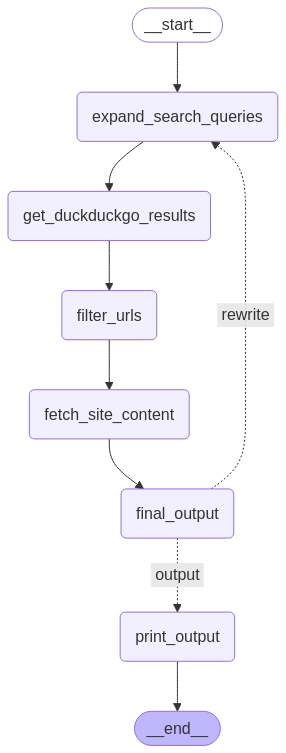

In [33]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [34]:
user_query = "what are some less crowded tourist plalces in paris"


In [35]:
inputs = {
    "query": user_query,
    "feedback":"",
    "max_results":1
}

In [36]:
response = graph.invoke(inputs)

---EXPAND SEARCH QUERIES---
expanded_search_queries: 
 ['less crowded tourist attractions in Paris', 'hidden gems in Paris for tourists', 'off-the-beaten-path places to visit in Paris']
---GETTING DUCKDUCKGO RESULTS---
---FILTER URLS---
filtered_urls: 
 ['https://www.wanderingsunsets.com/hidden-gems-in-paris/', 'https://maycausewanderlust.com/paris-off-the-beaten-path/']
---FETCH SITE CONTENT---
---SUMMARIZE CONTENT---
---SUMMARIZE CONTENT---
---CRAFTING FINAL RESPONSE---
---GRADING ANSWERS---
---DECISION: INFO RELEVANT---
---FINAL OUTPUT---
If you're looking to explore less crowded tourist spots in Paris, there are several hidden gems that offer a more tranquil experience away from the bustling crowds:

1. **Passage des Panoramas**: This is the oldest covered walkway in Paris, located at 11 Boulevard Montmartre, featuring unique boutiques and ethnic restaurants [1].

2. **Rue Cremieux**: Known for its pastel-colored houses, this colorful cobblestone street in a residential area offers

# Support Chatbot with Web Search and Memory

In [37]:
import os
from mem0 import Memory
from datetime import datetime
from langchain_core.tools import tool
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate


Convert the web_search graph into a tool

In [38]:
@tool
def web_search(user_query):
  """Search the web for the given query and return a summary of most relevant results to the provided query.
  """
  inputs = {
    "query": user_query,
    "feedback":"",
    "max_results":2
  }
  return graph.invoke(inputs)


At the Current Moment, there is some issue with Azure Open AI integration with mem0. For the time being, we will use mem0 API. Note that, you can use Mem0 with many open source models. Check out [Mem0 Docs](https://docs.mem0.ai/components/llms/models/openai)

Get the Mem0 API key by following instruction [here](https://docs.mem0.ai/quickstart#get-api-key) and add it to colab secrets.

In [52]:
from mem0 import MemoryClient

# allows you to securely store and retrieve user-specific data, such as API keys or credentials, without exposing them in the notebook
# from google.colab import userdata

In [53]:
# with open("/content/.mem0_api_key", "w") as f:
#     f.write("")

In [50]:
from pydantic import SecretStr # for wrapping the openai key in a secret for use with self.client

In [66]:
class SupportChatbot:
    def __init__(self):
        """
        Initialize the SupportChatbot class, setting up memory, the LLM client, tools, and the agent executor.
        """

        # Initialize a memory client to store and retrieve customer interactions
        #self.memory = MemoryClient(api_key=userdata.get("mem0"))
        # with open("/content/.mem0_api_key", "r") as f:
        #   mem0_api_key = f.read().strip()
        #   self.memory = MemoryClient(api_key=mem0_api_key)



        mem0_api_key = os.getenv('mem0_api_key')

        # Initialize MemoryClient with the correct API key
        self.memory = MemoryClient(api_key=mem0_api_key)

        # Initialize the Azure OpenAI client using the provided credentials
        # self.client = AzureChatOpenAI(
        #     model_name="gpt-4o",  # Specify the model to use (e.g., GPT-4 optimized version)
        #     api_key=cred1['AZURE_OPENAI_KEY'],  # API key for authentication
        #     azure_endpoint=cred1['AZURE_OPENAI_ENDPOINT'],  # Endpoint URL for Azure OpenAI
        #     api_version=cred1['AZURE_OPENAI_APIVERSION'],  # API version being used
        #     temperature=0  # Controls randomness in responses; 0 ensures deterministic results
        # )



        openai.api_key = os.getenv('OPENAI_API_KEY')
        self.client = ChatOpenAI(model="gpt-4o", api_key= openai.api_key, temperature=0)

        # Define tools available to the chatbot, such as web search
        tools = [web_search]

        # Define the system prompt to set the behavior of the chatbot
        system_prompt = """
        You are a helpful customer support agent that helps customers with travel-related suggestions.
        Use the following guidelines:
        - Be polite and professional
        - Show empathy for customer issues
        - Reference past interactions when relevant
        - Ask the customer their likes and dislikes before responding to tailor suggestions
        - Maintain consistent information across conversations
        - If you're unsure about something, ask for clarification
        - Always use the web search tool to get up-to-date information
        - Keep track of open issues and follow-ups
        """

        # Build the prompt template for the agent
        prompt = ChatPromptTemplate.from_messages([
            ("system", system_prompt),  # System instructions
            ("human", "{input}"),  # Placeholder for human input
            ("placeholder", "{agent_scratchpad}")  # Placeholder for intermediate reasoning steps
        ])

        # Create an agent capable of interacting with tools and executing tasks
        agent = create_tool_calling_agent(self.client, tools, prompt)

        # Wrap the agent in an executor to manage tool interactions and execution flow
        self.agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    def store_customer_interaction(self, user_id: str, message: str, response: str, metadata: Dict = None):
        """
        Store customer interaction in memory for future reference.

        Args:
            user_id (str): Unique identifier for the customer.
            message (str): Customer's query or message.
            response (str): Chatbot's response.
            metadata (Dict, optional): Additional metadata for the interaction.
        """
        if metadata is None:
            metadata = {}

        # Add a timestamp to the metadata for tracking purposes
        metadata["timestamp"] = datetime.now().isoformat()

        # Format the conversation for storage
        conversation = [
            {"role": "user", "content": message},
            {"role": "assistant", "content": response}
        ]

        # Store the interaction in the memory client
        self.memory.add(
            conversation,
            user_id=user_id,
            metadata=metadata
        )

    def get_relevant_history(self, user_id: str, query: str) -> List[Dict]:
        """
        Retrieve past interactions relevant to the current query.

        Args:
            user_id (str): Unique identifier for the customer.
            query (str): The customer's current query.

        Returns:
            List[Dict]: A list of relevant past interactions.
        """
        return self.memory.search(
            query=query,  # Search for interactions related to the query
            user_id=user_id,  # Restrict search to the specific user
            limit=5  # Retrieve up to 5 relevant interactions
        )

    def handle_customer_query(self, user_id: str, query: str) -> str:
        """
        Process a customer's query and provide a response, taking into account past interactions.

        Args:
            user_id (str): Unique identifier for the customer.
            query (str): Customer's query.

        Returns:
            str: Chatbot's response.
        """

        # Retrieve relevant past interactions for context
        relevant_history = self.get_relevant_history(user_id, query)

        # Build a context string from the relevant history
        context = "Previous relevant interactions:\n"
        for memory in relevant_history:
            context += f"Customer: {memory['memory']}\n"  # Customer's past messages
            context += f"Support: {memory['memory']}\n"  # Chatbot's past responses
            context += "---\n"

        # Print context for debugging purposes
        print("Context: ", context)

        # Prepare a prompt combining past context and the current query
        prompt = f"""
        Context:
        {context}

        Current customer query: {query}

        Provide a helpful response that takes into account any relevant past interactions.
        """

        # Generate a response using the agent
        response = self.agent_executor.invoke({"input": prompt})

        # Store the current interaction for future reference
        self.store_customer_interaction(
            user_id=user_id,
            message=query,
            response=response["output"],
            metadata={"type": "support_query"}
        )

        # Return the chatbot's response
        return response['output']


1. Assume a User Persona and Specify Preferences

Example:

Persona Name: Samay

Preferences: Enjoys dining at iconic city restaurants and exploring internet-famous eateries.

Task: Plan an itinerary that aligns with Samay's preferences, including suitable hotel recommendations.

Action: After completing the task, end the session by typing "exit."

2. Initiate a New Session with a Different Persona

Example:

Persona Name: Jay
Preferences: Prefers vibrant nightlife and is interested in top party destinations, disregarding typical sunrise and sunset spots.
Task: Identify locations renowned for exceptional parties.

Action: After completing the task, end the session by typing "exit."

3. Re-engage as the Initial Persona (Samay) for a New Destination

Task: Request an itinerary for a different city without specifying preferences. The system should automatically generate a plan tailored to Samay's known interests.

In [67]:
chatbot = SupportChatbot()
print("Login by providing customer name") # This provides way for us to initiate chat as different users.
user_id = input()
print("Welcome to Customer Support! How can I help you? Type 'exit' to end the conversation.")

while True:
    # Get user input
    query = input()
    print("Customer:", query)

    # Check if user wants to exit
    if query.lower() == 'exit':
        print("Thank you for using our support service. Goodbye!")
        break

    # Handle the query and print the response
    response = chatbot.handle_customer_query(user_id, query)
    print("Support:", response, "\n\n")

Login by providing customer name
soumukhe
Welcome to Customer Support! How can I help you? Type 'exit' to end the conversation.
show me some nice places to visit in Texas
Customer: show me some nice places to visit in Texas
Context:  Previous relevant interactions:



> Entering new AgentExecutor chain...
Thank you for reaching out! I'd be delighted to help you find some wonderful places to visit in Texas. To tailor my suggestions to your preferences, could you please share some of your likes and dislikes when it comes to travel? For example, are you interested in outdoor activities, historical sites, cultural experiences, or perhaps something else? Let me know, and I'll provide recommendations that suit your interests!

> Finished chain.


/usr/local/lib/python3.11/dist-packages/mem0/client/main.py:32: DeprecationWarning: Using default output format 'v1.0' is deprecated and will be removed in version 0.1.70. Please use output_format='v1.1' for enhanced memory details. Check out the docs for more information: https://docs.mem0.ai/platform/quickstart#4-1-create-memories
  return func(*args, **kwargs)


Support: Thank you for reaching out! I'd be delighted to help you find some wonderful places to visit in Texas. To tailor my suggestions to your preferences, could you please share some of your likes and dislikes when it comes to travel? For example, are you interested in outdoor activities, historical sites, cultural experiences, or perhaps something else? Let me know, and I'll provide recommendations that suit your interests! 


outdoor activities, historical sites
Customer: outdoor activities, historical sites
Context:  Previous relevant interactions:
Customer: Looking for nice places to visit in Texas
Support: Looking for nice places to visit in Texas
---



> Entering new AgentExecutor chain...

Invoking: `web_search` with `{'user_query': 'outdoor activities in Texas'}`


---EXPAND SEARCH QUERIES---
expanded_search_queries: 
 ['- Best outdoor activities to do in Texas', '- Top hiking and camping spots in Texas', '- Family-friendly outdoor adventures in Texas']
---GETTING DUCKDUCKG

/usr/local/lib/python3.11/dist-packages/mem0/client/main.py:32: DeprecationWarning: Using default output format 'v1.0' is deprecated and will be removed in version 0.1.70. Please use output_format='v1.1' for enhanced memory details. Check out the docs for more information: https://docs.mem0.ai/platform/quickstart#4-1-create-memories
  return func(*args, **kwargs)


Support: Based on your interest in outdoor activities and historical sites in Texas, here are some tailored suggestions:

### Outdoor Activities:
1. **Big Bend National Park**: Known for its diverse landscapes, it's perfect for camping, hiking, and nature watching. It's an International Biosphere Reserve offering a variety of outdoor adventures [1][2].
2. **Palo Duro Canyon**: Often referred to as the "Grand Canyon of Texas," this site is ideal for mountain biking, horseback riding, and hiking [1][2].
3. **Hamilton Pool Nature Preserve**: Near Austin, this historic swimming hole features a 50-foot waterfall, offering a refreshing outdoor experience [1].
4. **San Marcos River**: A popular tubing destination to enjoy the Texas heat [1].
5. **Hueco Tanks State Historic Site**: Offers camping and rock climbing, and is known for its prehistoric pictographs [2].

### Historical Sites:
1. **The Alamo** in San Antonio: A symbol of Texan independence, known for the 1836 Battle of the Alamo [3].

Navigate to users in your mem0 dashboard to find memories stored - [Dashboard](https://app.mem0.ai/dashboard/users)

**Power Ahead!**